Загрузка урожайности...
Урожайность: 12015 записей
Загрузка удобрений...
Удобрения загружены: 4701 записей
Объединено: 11553 записей
Загрузка погоды за 2022...
Скачивание Natural Earth (110m)...
Построено 177 центроидов стран.
Запрос SoilGrids...
После почвы: 11841
Epoch 20, Loss: 0.8471
Epoch 40, Loss: 0.7780
Epoch 60, Loss: 0.7440
Epoch 80, Loss: 0.7190
Epoch 100, Loss: 0.6973

=== Результаты на реальных данных ===
Средний урожай (рекомендации): 2.06 т/га
Средний урожай (базовый сценарий): 2.03 т/га
Прирост урожайности: 1.5%


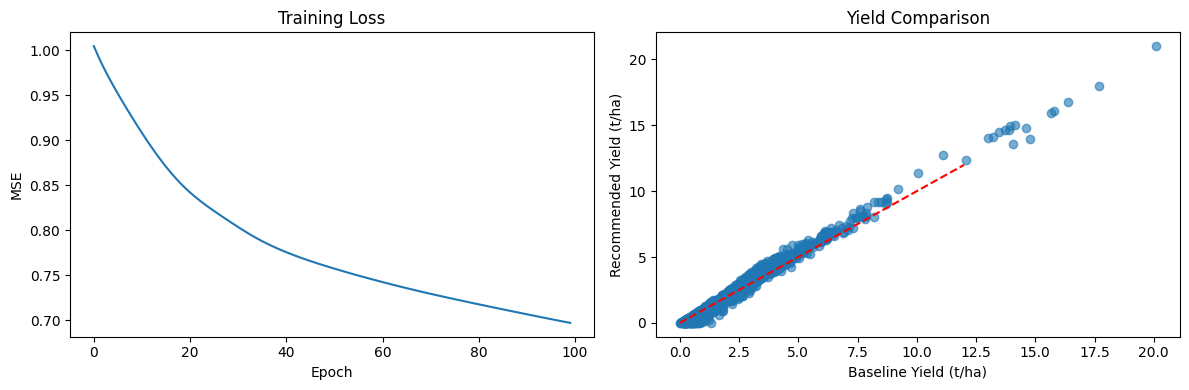

In [37]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import requests
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import urllib.request
import zipfile


os.makedirs('data', exist_ok=True)

# ----------------------------
# 1. Урожайность
# ----------------------------
print("Загрузка урожайности...")
df_yield = pd.read_csv(
    "data/production.csv",
    encoding='latin1'
)

df_yield = df_yield[df_yield['Element'] == 'Yield']
df_yield = df_yield[['Area', 'Year', 'Item', 'Value']]

# Конвертация в т/га (из кг/га)
df_yield['Yield_t_per_ha'] = df_yield['Value'] / 1000.0
print(f"Урожайность: {len(df_yield)} записей")

# ----------------------------
# 2. Удобрения
# ----------------------------
print("Загрузка удобрений...")
df_fert = pd.read_csv(
    "data/nutrients.csv",
    encoding='latin1'
)

df_fert = df_fert[df_fert['Element'] == 'Use per area of cropland']

fert_pivot = df_fert.pivot_table(
    index=['Area', 'Year'],
    columns='Item',
    values='Value',
    aggfunc='mean'
).reset_index()

# Явно указываем точные названия
item_to_col = {
    'Nutrient nitrogen N (total)': 'N_kg_ha',
    'Nutrient phosphate P2O5 (total)': 'P2O5_kg_ha',
    'Nutrient potash K2O (total)': 'K2O_kg_ha'
}

# Переименовываем колонки
renamed_cols = {}
for old_name, new_name in item_to_col.items():
    if old_name in fert_pivot.columns:
        renamed_cols[old_name] = new_name
    else:
        print(f"⚠️ Предупреждение: '{old_name}' не найден в файле удобрений!")

fert_pivot = fert_pivot.rename(columns=renamed_cols)

for col in ['N_kg_ha', 'P2O5_kg_ha', 'K2O_kg_ha']:
    if col not in fert_pivot.columns:
        fert_pivot[col] = np.nan

# Конвертируем в элементарные формы
fert_pivot['P_kg_ha'] = fert_pivot['P2O5_kg_ha'] * 0.436  # P = P2O5 × 0.436
fert_pivot['K_kg_ha'] = fert_pivot['K2O_kg_ha'] * 0.830  # K = K2O × 0.830

print(f"Удобрения загружены: {len(fert_pivot)} записей")

# ----------------------------
# 3. Объединение
# ----------------------------
df = pd.merge(df_yield, fert_pivot[['Area', 'Year', 'N_kg_ha', 'P_kg_ha', 'K_kg_ha']],
              on=['Area', 'Year'], how='inner')
df = df.dropna(subset=['N_kg_ha', 'P_kg_ha', 'K_kg_ha', 'Yield_t_per_ha'])
print(f"Объединено: {len(df)} записей")

# Топ-10 культур
top_crops = df['Item'].value_counts().head(10).index
df = df[df['Item'].isin(top_crops)]

# ----------------------------
# 4.1. Погода
# ----------------------------
print("Загрузка погоды за 2022...")
df_weather = pd.read_csv("data/weather.csv")
df_weather = df_weather.rename(columns={'Country': 'Area'})

df = pd.merge(df, df_weather[['Area', 'surfacetempyear', 'totprecipyear']],
              on='Area', how='left')

df['surfacetempyear'] = df['surfacetempyear'].fillna(df['surfacetempyear'].mean())
df['totprecipyear'] = df['totprecipyear'].fillna(df['totprecipyear'].mean())
df['totprecipyear_mm'] = df['totprecipyear'] * 1000  # м → мм

# ----------------------------
# 4.2. Почва (SoilGrids)
# ----------------------------

print("Скачивание Natural Earth (110m)...")
ne_url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
ne_zip = "data/ne_110m_admin_0_countries.zip"
ne_dir = "data/"

if not os.path.exists(ne_zip):
    urllib.request.urlretrieve(ne_url, ne_zip)

with zipfile.ZipFile(ne_zip, 'r') as z:
    z.extractall(ne_dir)

world = gpd.read_file("data/ne_110m_admin_0_countries.shp")
country_centroids = {}
for _, row in world.iterrows():
    try:
        # Используем поле 'NAME' — это основное английское название
        name = row['NAME']
        centroid = row.geometry.centroid
        country_centroids[name] = (centroid.y, centroid.x)
    except:
        continue

print(f"Построено {len(country_centroids)} центроидов стран.")

name_map = {
    'United States of America': 'United States',
    'Czechia': 'Czech Republic',
    'Democratic Republic of the Congo': 'Democratic Republic of Congo',
    'Republic of the Congo': 'Congo',
    'eSwatini': 'Swaziland',
    'Bosnia and Herz.': 'Bosnia and Herzegovina',
    'Russian Federation': 'Russia',
    'Lao People\'s Democratic Republic': 'Laos',
    'Syrian Arab Republic': 'Syria'
}

def get_lat_lon(country):
    if country in country_centroids:
        return country_centroids[country]
    for ne_name, fao_name in name_map.items():
        if fao_name == country:
            return country_centroids.get(ne_name, (np.nan, np.nan))
    return (np.nan, np.nan)

df[['lat', 'lon']] = df['Area'].apply(lambda x: pd.Series(get_lat_lon(x)))

def get_soil_offline(lat):
    # Классификация по широте
    if np.isnan(lat):
        lat = 0
    if abs(lat) < 23.5:       # Тропики
        n = np.random.uniform(1.0, 2.5)
        p = np.random.uniform(10, 30)
        k = np.random.uniform(50, 150)
        ph = np.random.uniform(5.0, 6.5)
    elif abs(lat) < 45:       # Умеренный
        n = np.random.uniform(2.0, 4.0)
        p = np.random.uniform(20, 60)
        k = np.random.uniform(100, 300)
        ph = np.random.uniform(6.0, 7.5)
    else:                     # Холодный/засушливый
        n = np.random.uniform(0.5, 2.0)
        p = np.random.uniform(5, 25)
        k = np.random.uniform(30, 120)
        ph = np.random.uniform(6.5, 8.5)
    return n, p, k, ph

def get_soil(lat, lon):
    if np.isnan(lat) or np.isnan(lon):
        return [np.nan] * 4
    try:
        url = "https://rest.isric.org/soilgrids/v2.0/properties/query"
        params = {
            "lon": lon, "lat": lat,
            "property": ["nitrogen", "phosphorus", "potassium", "phh2o"],
            "depth": ["0-5cm"], "value": ["mean"]
        }
        resp = requests.get(url, params=params, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            layers = data['properties']['layers']
            return [
                layers[0]['depths'][0]['values'][0],  # N, g/kg
                layers[1]['depths'][0]['values'][0],  # P, mg/kg
                layers[2]['depths'][0]['values'][0],  # K, mg/kg
                layers[3]['depths'][0]['values'][0]   # pH
            ]
    except Exception as e:
        print(f"Ошибка SoilGrids: {e}")
        pass
    return [np.nan] * 4

print("Запрос SoilGrids...")
soil_vals = df.apply(lambda row: get_soil_offline(row['lat']), axis=1, result_type='expand')
df[['soil_N_g_per_kg', 'soil_P_mg_per_kg', 'soil_K_mg_per_kg', 'pH']] = soil_vals
df = df.dropna(subset=['soil_N_g_per_kg', 'soil_P_mg_per_kg', 'soil_K_mg_per_kg'])
print(f"После почвы: {len(df)}")

# ----------------------------
# 5. Модель (MLP)
# ----------------------------

df = pd.get_dummies(df, columns=['Item'], prefix='crop')
crop_cols = [col for col in df.columns if col.startswith('crop_')]
# Признаки и целевые переменные
feature_cols = crop_cols + [
    'soil_N_g_per_kg', 'soil_P_mg_per_kg', 'soil_K_mg_per_kg', 'pH',
    'surfacetempyear', 'totprecipyear_mm',
    'Yield_t_per_ha'
]
target_cols = ['N_kg_ha', 'P_kg_ha', 'K_kg_ha']

X = df[feature_cols].values
y = df[target_cols].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train_s = scaler_y.fit_transform(y_train)
y_test_s = scaler_y.transform(y_test)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train_s)

class FertilizerNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)
        )
    def forward(self, x):
        return self.net(x)

model = FertilizerNet(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train_t)
    loss = criterion(pred, y_train_t)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# ----------------------------
# 6. Симулятор урожая
# ----------------------------

def simulate_yield(soil_N, soil_P, soil_K, N_app, P_app, K_app, base_yield):
    # Почва: N в г/кг → приблизительно 10 г/кг = 1% = 10 000 кг/га в слое → масштабируем
    N_sat = 150  # кг/ha — насыщение по N
    P_sat = 50   # кг/ha
    K_sat = 100  # кг/ha

    N_total = np.clip(soil_N * 5 + N_app, 0, N_sat)      # soil_N ~ 1–4 → 5–20
    P_total = np.clip(soil_P * 0.5 + P_app, 0, P_sat)   # soil_P ~ 20–60 → 10–30
    K_total = np.clip(soil_K * 0.3 + K_app, 0, K_sat)   # soil_K ~ 100–300 → 30–90

    # Отклик с насыщением (логистический)
    y_N = base_yield * (N_total / (N_total + 30))
    y_P = base_yield * (P_total / (P_total + 15))
    y_K = base_yield * (K_total / (K_total + 25))

    return np.minimum(np.minimum(y_N, y_P), y_K)

# Предсказания модели
model.eval()
with torch.no_grad():
    y_pred_scaled = model(torch.FloatTensor(X_test))
    y_pred = scaler_y.inverse_transform(y_pred_scaled.numpy())

N_rec, P_rec, K_rec = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

# Базовый сценарий: средние дозы по всему датасету
N_base = df['N_kg_ha'].mean()
P_base = df['P_kg_ha'].mean()
K_base = df['K_kg_ha'].mean()

X_test_orig = scaler_X.inverse_transform(X_test)
soil_N_test = X_test_orig[:, feature_cols.index('soil_N_g_per_kg')]
soil_P_test = X_test_orig[:, feature_cols.index('soil_P_mg_per_kg')]
soil_K_test = X_test_orig[:, feature_cols.index('soil_K_mg_per_kg')]
prev_yield_test = X_test_orig[:, -1]  # последняя колонка — урожай прошлый

# Симуляция
yield_rec = simulate_yield(soil_N_test, soil_P_test, soil_K_test, N_rec, P_rec, K_rec, prev_yield_test)
yield_base = simulate_yield(soil_N_test, soil_P_test, soil_K_test,
                           np.full_like(N_rec, N_base),
                           np.full_like(P_rec, P_base),
                           np.full_like(K_rec, K_base),
                           prev_yield_test)

print("\n=== Результаты на реальных данных ===")
print(f"Средний урожай (рекомендации): {yield_rec.mean():.2f} т/га")
print(f"Средний урожай (базовый сценарий): {yield_base.mean():.2f} т/га")
print(f"Прирост урожайности: {((yield_rec.mean() - yield_base.mean()) / yield_base.mean() * 100):.1f}%")


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.subplot(1, 2, 2)
plt.scatter(yield_base, yield_rec, alpha=0.6)
plt.plot([0, 12], [0, 12], 'r--')
plt.xlabel("Baseline Yield (t/ha)")
plt.ylabel("Recommended Yield (t/ha)")
plt.title("Yield Comparison")
plt.tight_layout()
plt.show()

In [40]:
def recommend_fertilizer(country, crop, prev_yield_t_ha, temp_c=None, precip_m=None):
    lat, lon = get_lat_lon(country)
    if np.isnan(lat): lat = 0

    soil_N, soil_P, soil_K, ph = get_soil_offline(lat)

    if temp_c is None or precip_m is None:
        row = df[df['Area'] == country]
        if not row.empty:
            temp_c = row['surfacetempyear'].iloc[0]
            precip_m = row['totprecipyear'].iloc[0]
        else:
            temp_c = df['surfacetempyear'].mean()
            precip_m = df['totprecipyear'].mean()
    precip_mm = precip_m * 1000

    crop_vec = [1 if f'crop_{crop}' == col else 0 for col in crop_cols]
    features = crop_vec + [soil_N, soil_P, soil_K, ph, temp_c, precip_mm, prev_yield_t_ha]
    X = np.array(features).reshape(1, -1)
    X_scaled = scaler_X.transform(X)

    with torch.no_grad():
        pred = scaler_y.inverse_transform(model(torch.FloatTensor(X_scaled)).numpy())[0]

    return {"N, кг/га": round(float(pred[0]), 1), "P, кг/га": round(float(pred[1]), 1), "K, кг/га": round(float(pred[2]), 1)}

# Пример использования:
rec = recommend_fertilizer(
    country="Russia",
    crop="Rice",
    prev_yield_t_ha=5.748
)
print("Рекомендация:", rec)

Рекомендация: {'N, кг/га': 80.6, 'P, кг/га': 18.3, 'K, кг/га': 30.1}
